# Bikes

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from vi_evi import vi_evi

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
# We keep every 50th row
bikes = pd.read_csv("bikes_full.csv")[::50]

Y = bikes.pop("count")
X = bikes

We perform a first run to get the ranking of the variable importance.

In [4]:
with pm.Model() as model:
    α = pm.Exponential("α", 0.1)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ", np.exp(μ_))
    y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
    idata = pm.sample(
        chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


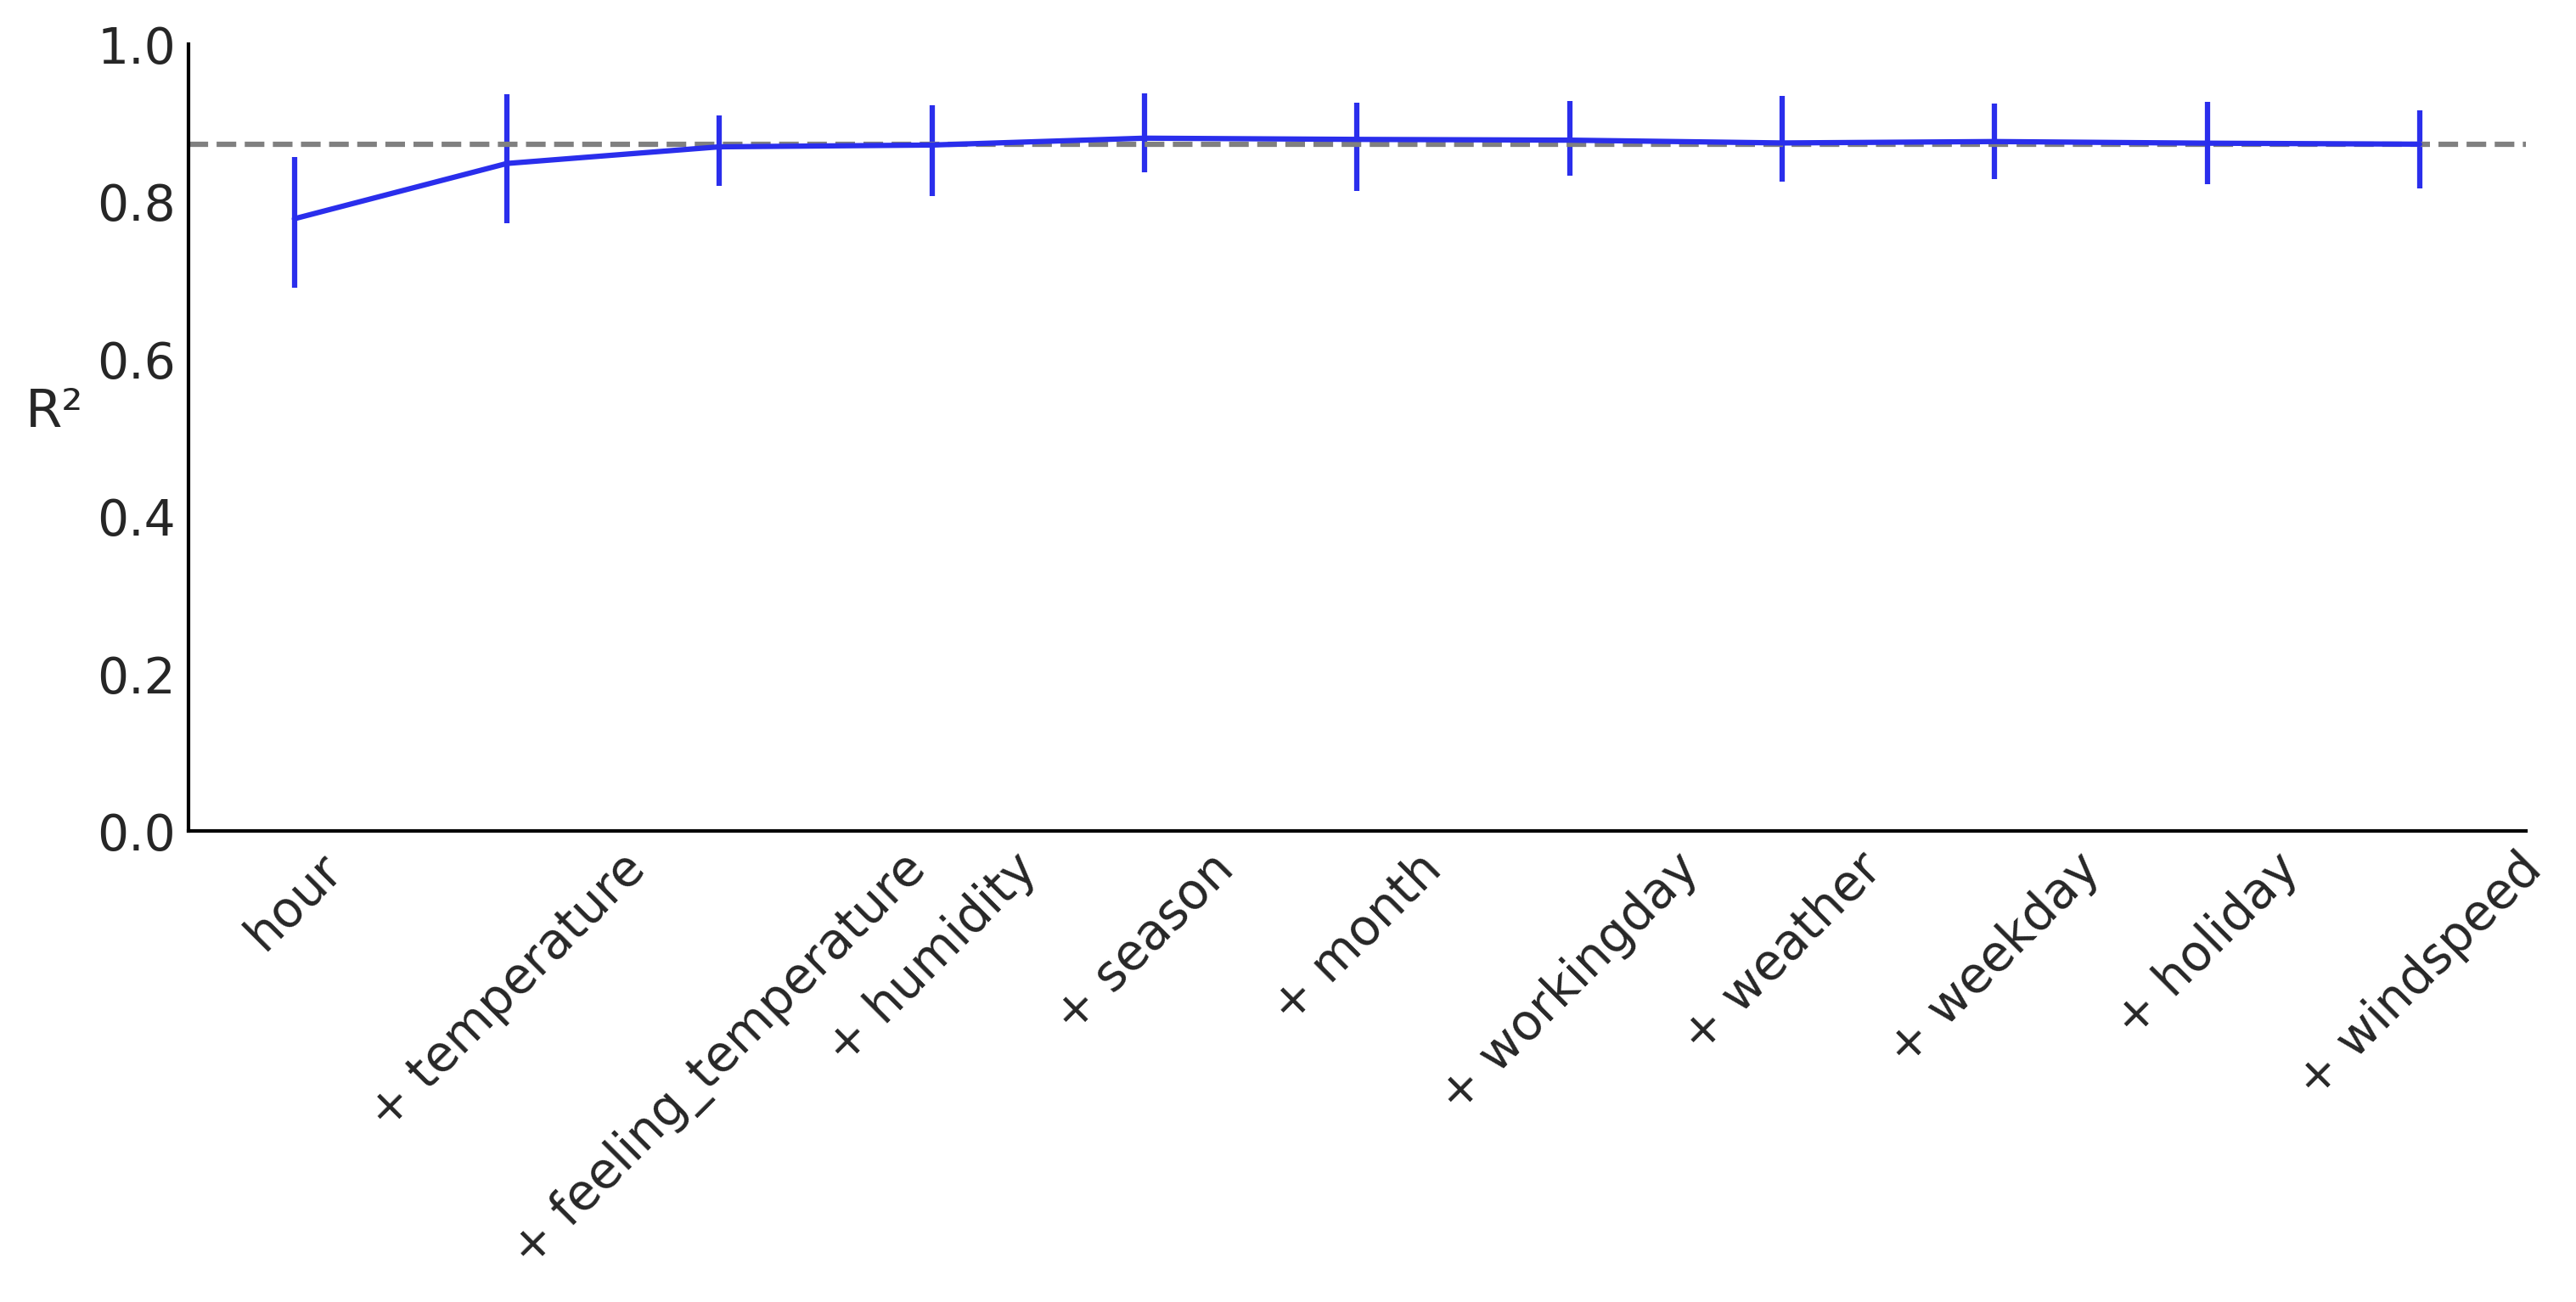

In [5]:
indices_vi, _ = pmb.utils.plot_variable_importance(
    idata, μ_, X, method="VI", xlabel_angle=45, figsize=(10, 5), random_seed=RANDOM_SEED
)

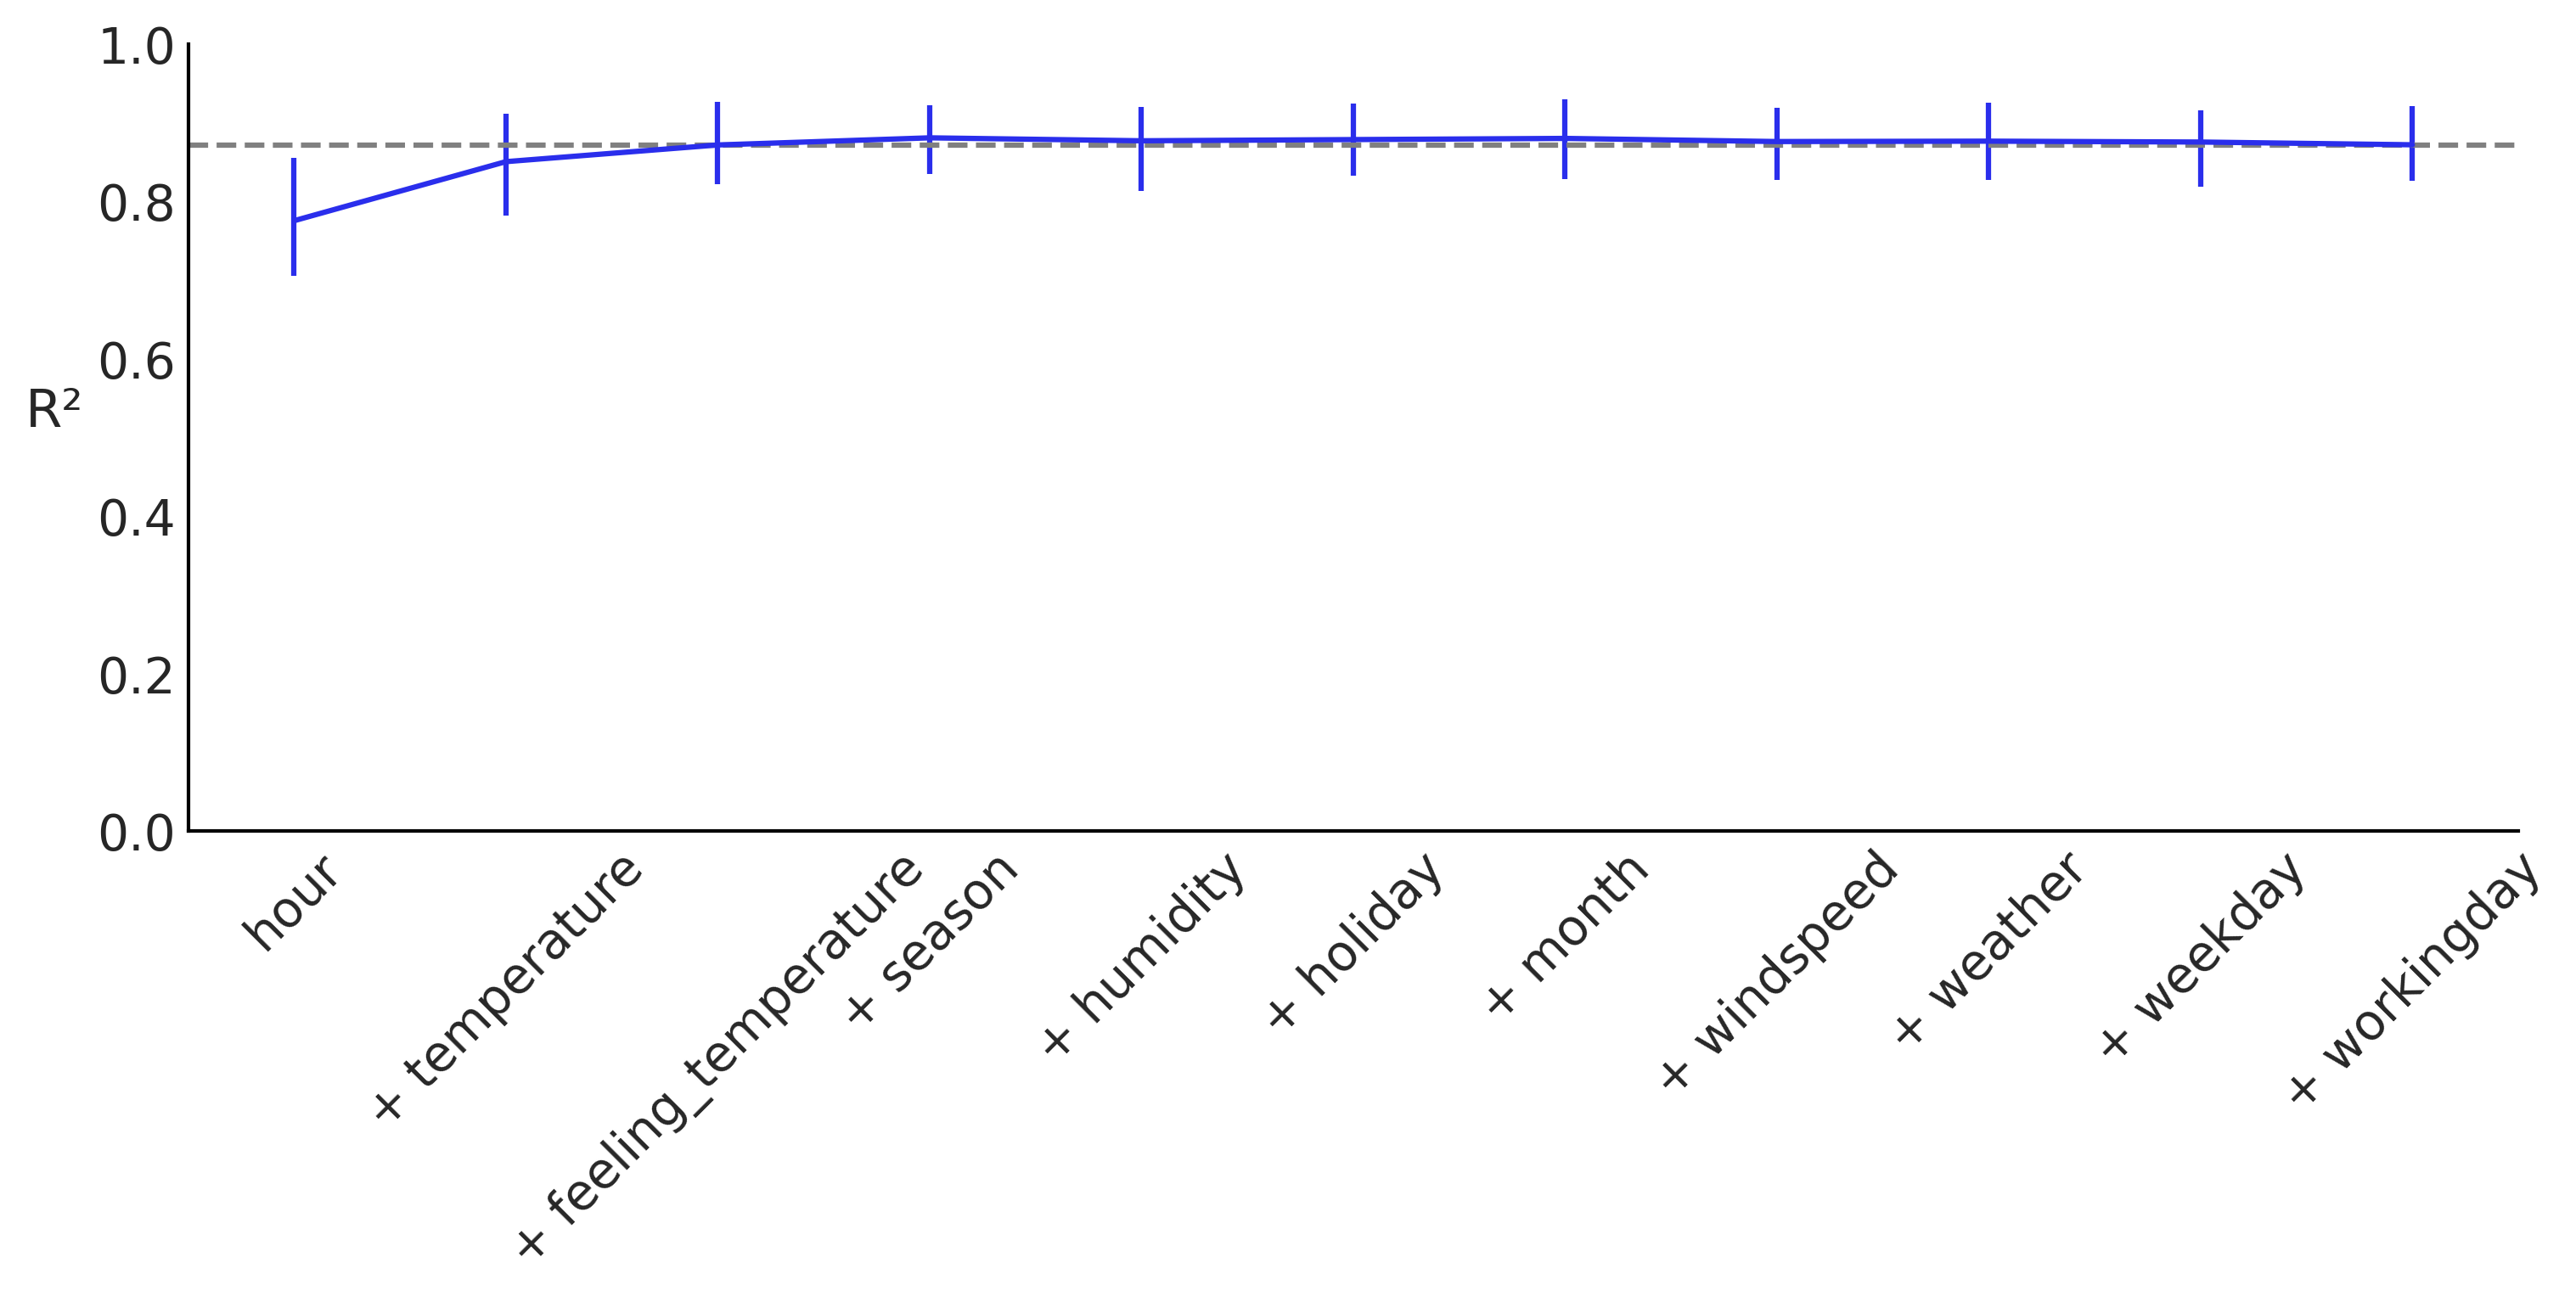

In [6]:
indices_bw, _ = pmb.utils.plot_variable_importance(
    idata,
    μ_,
    X,
    method="backward",
    xlabel_angle=45,
    figsize=(10, 5),
    random_seed=RANDOM_SEED,
)

## Explicit computation of R² following method="VI" order, with m=50

In [7]:
idatas = []
bart_rvs = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X.iloc[:, indices_vi[: idx + 1]], np.log(Y), m=50)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(
            chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False
        )
        idatas.append(idata)
        bart_rvs.append(μ_)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.


In [8]:
X.iloc[:, indices_vi[: X.shape[1] + 1]]

,hour,temperature,feeling_temperature,humidity,season,month,workingday,weather,weekday,holiday,windspeed
0,0,0.24,0.2879,0.81,1,1,0,1,6,0,0.0000
50,5,0.16,0.1364,0.47,1,1,1,1,1,0,0.2836
100,9,0.22,0.1970,0.37,1,1,1,1,3,0,0.3284
150,13,0.20,0.1818,0.37,1,1,1,2,5,0,0.2836
200,15,0.22,0.1970,0.35,1,1,0,1,0,0,0.3582
...,...,...,...,...,...,...,...,...,...,...,...
17150,9,0.26,0.2273,0.48,1,12,0,1,6,0,0.3881
17200,12,0.28,0.3030,0.56,1,12,1,2,1,0,0.0896
17250,15,0.26,0.2273,0.87,1,12,1,3,3,0,0.3582
17300,17,0.24,0.2424,0.60,1,12,1,1,5,0,0.1343


We now check that computing the predictions estimated by pruning the trees is close to the predictions if we actually ommits covariables and refit models.

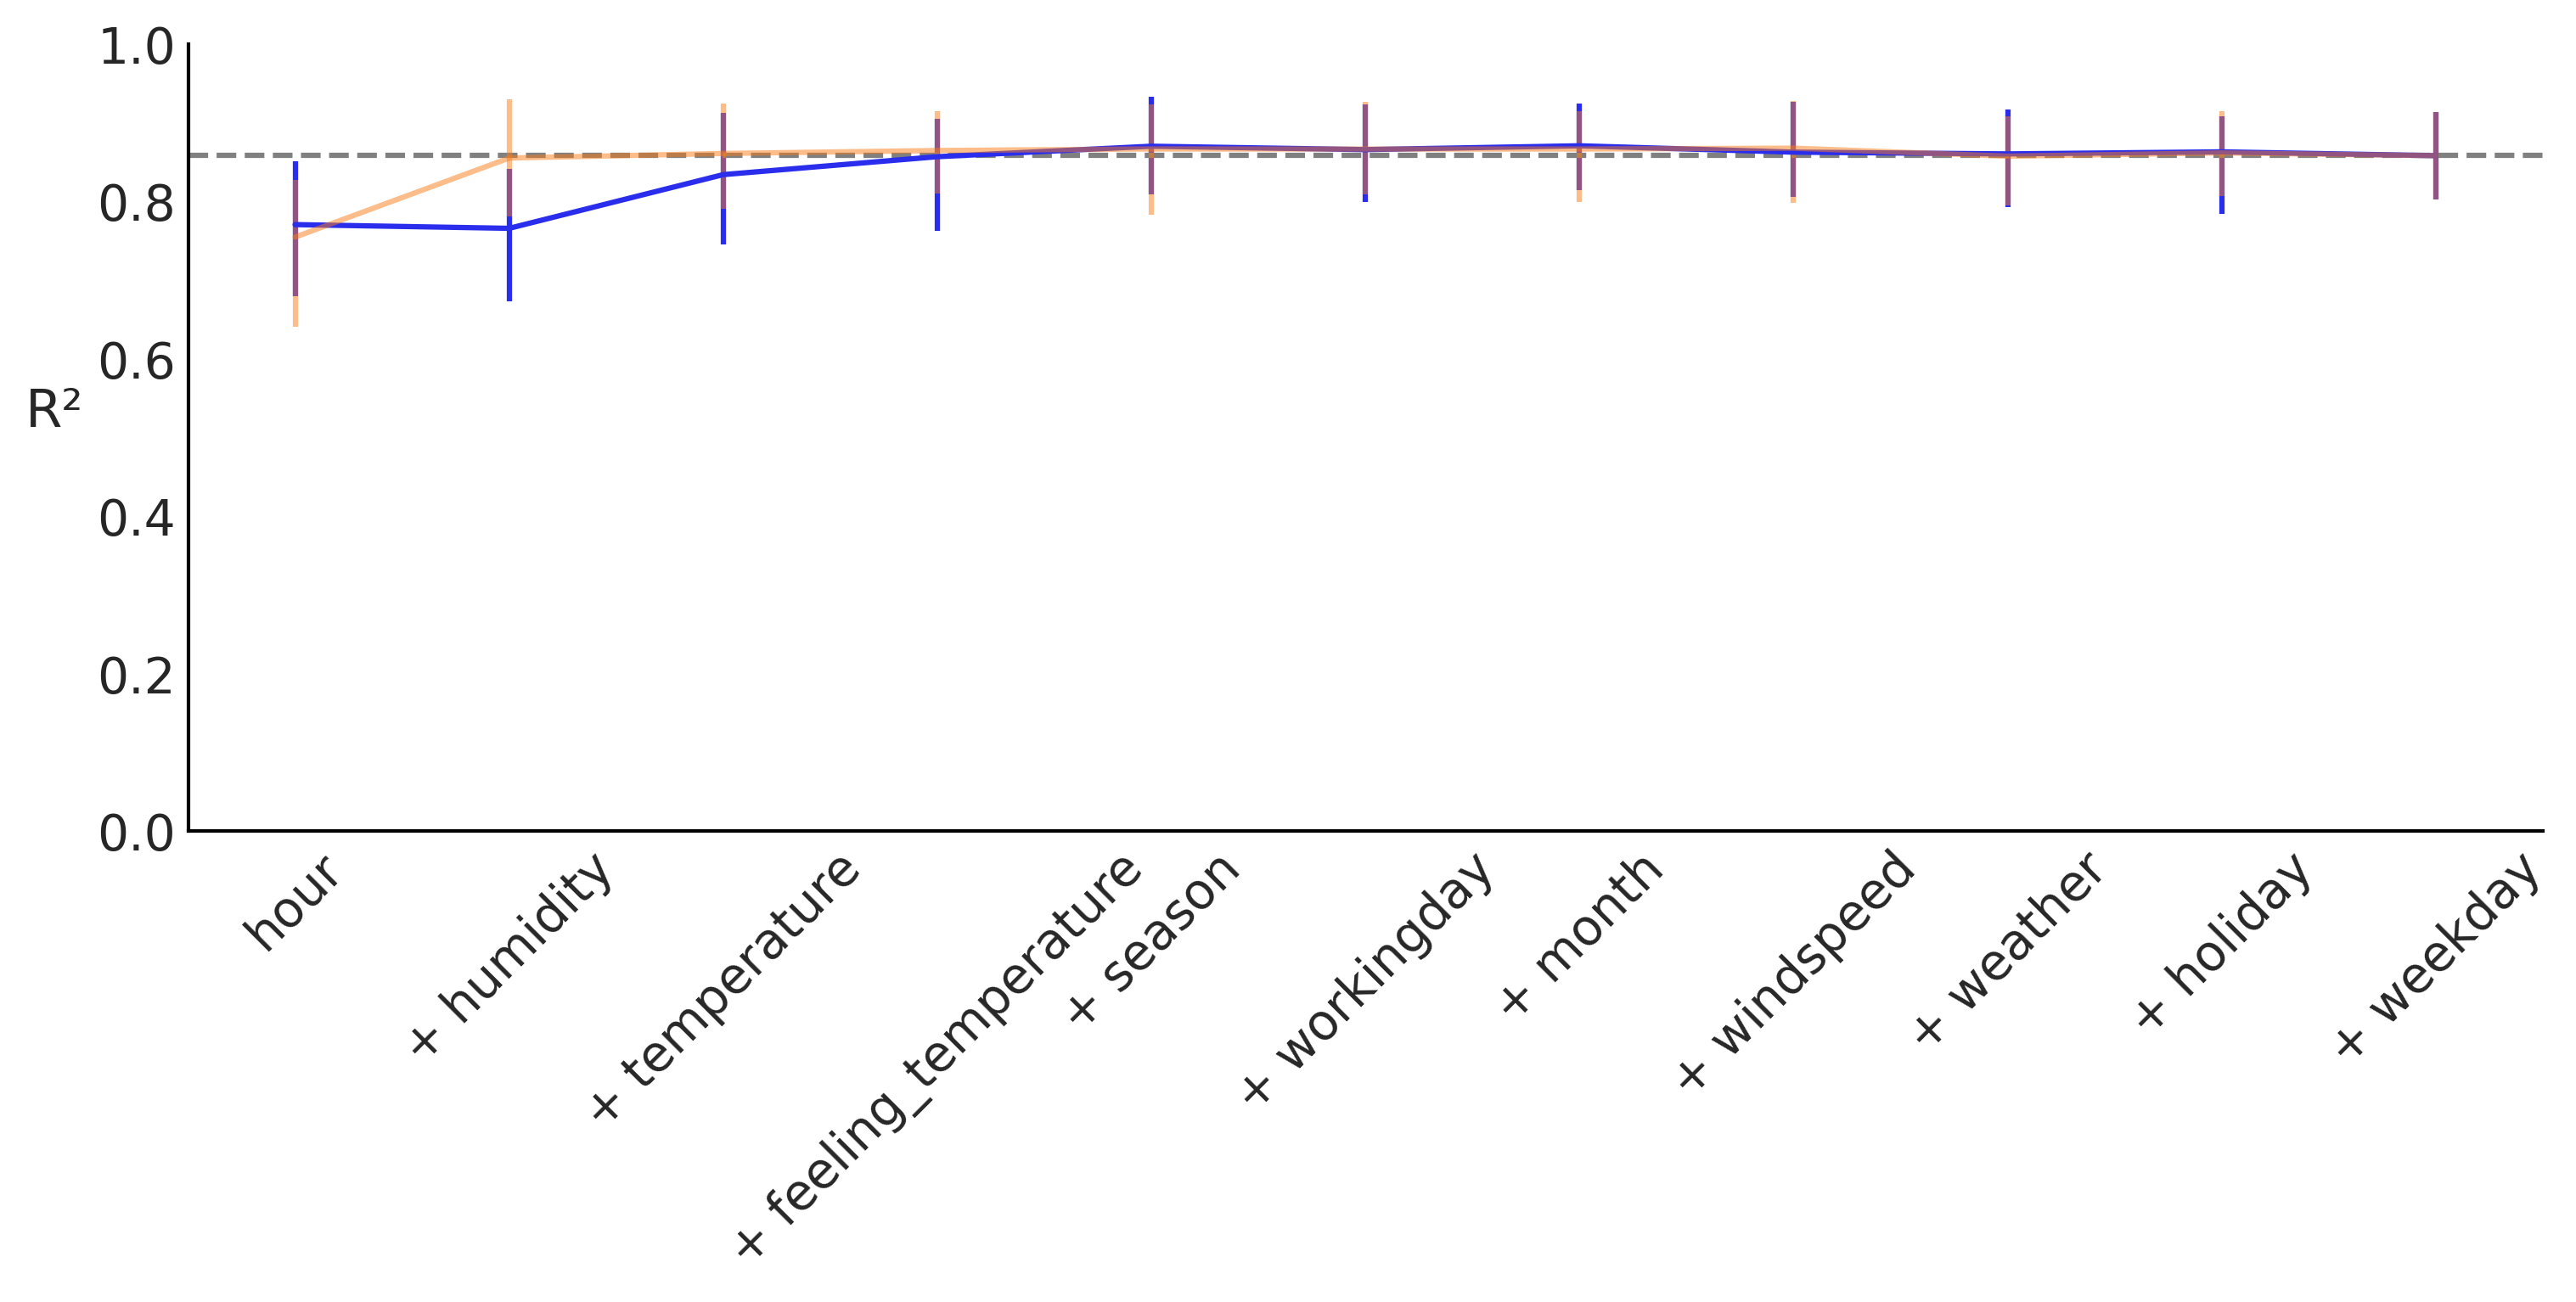

In [9]:
vi_evi(bart_rvs, idatas, X, indices_vi, "VI", 100, RANDOM_SEED, figsize=(10, 5))
plt.savefig("bikes_m50_vi.png")

## Explicit computation of R² following method="backward" order, with m=50

In [10]:
idatas = []
bart_rvs = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X.iloc[:, indices_bw[: idx + 1]], np.log(Y), m=50)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(
            chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False
        )
        idatas.append(idata)
        bart_rvs.append(μ_)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


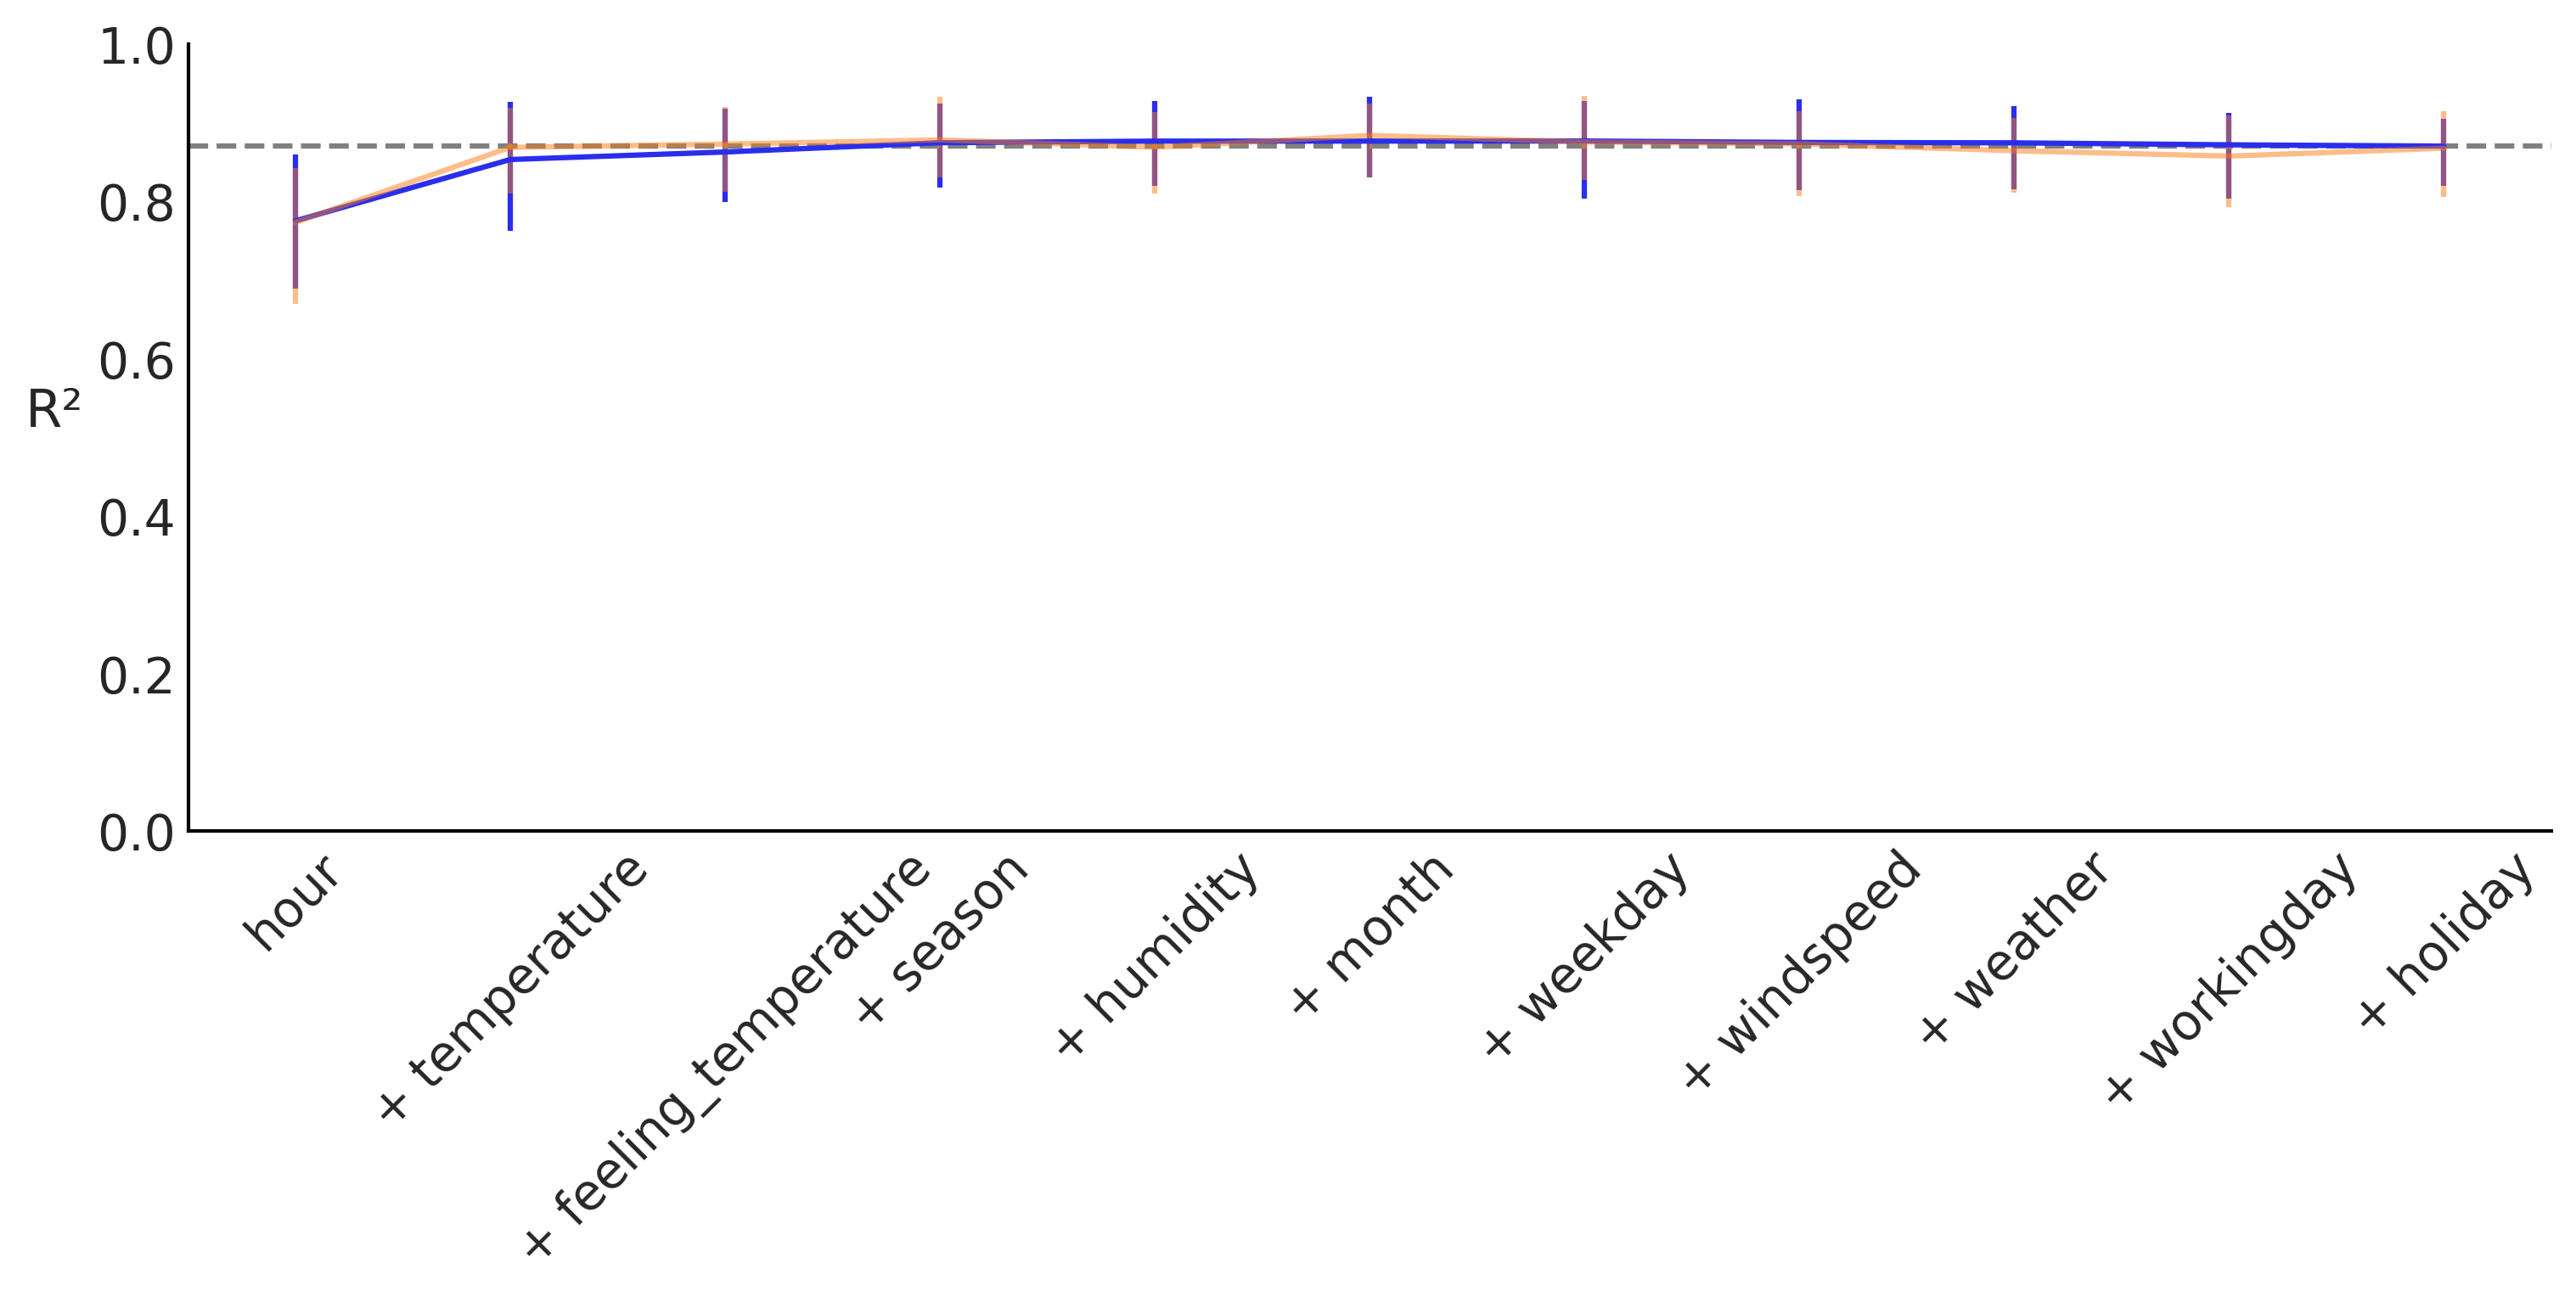

In [11]:
vi_evi(bart_rvs, idatas, X, indices_bw, "backward", 100, RANDOM_SEED, figsize=(10, 5))
plt.savefig("bikes_m50_bw.png")

## Explicit computation of R² following method="VI" order, with m=200  
First run to get the ranking of the variable importance.  

In [12]:
with pm.Model() as model:
    α = pm.Exponential("α", 0.1)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=200)
    μ = pm.Deterministic("μ", np.exp(μ_))
    y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
    idata = pm.sample(
        chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 369 seconds.


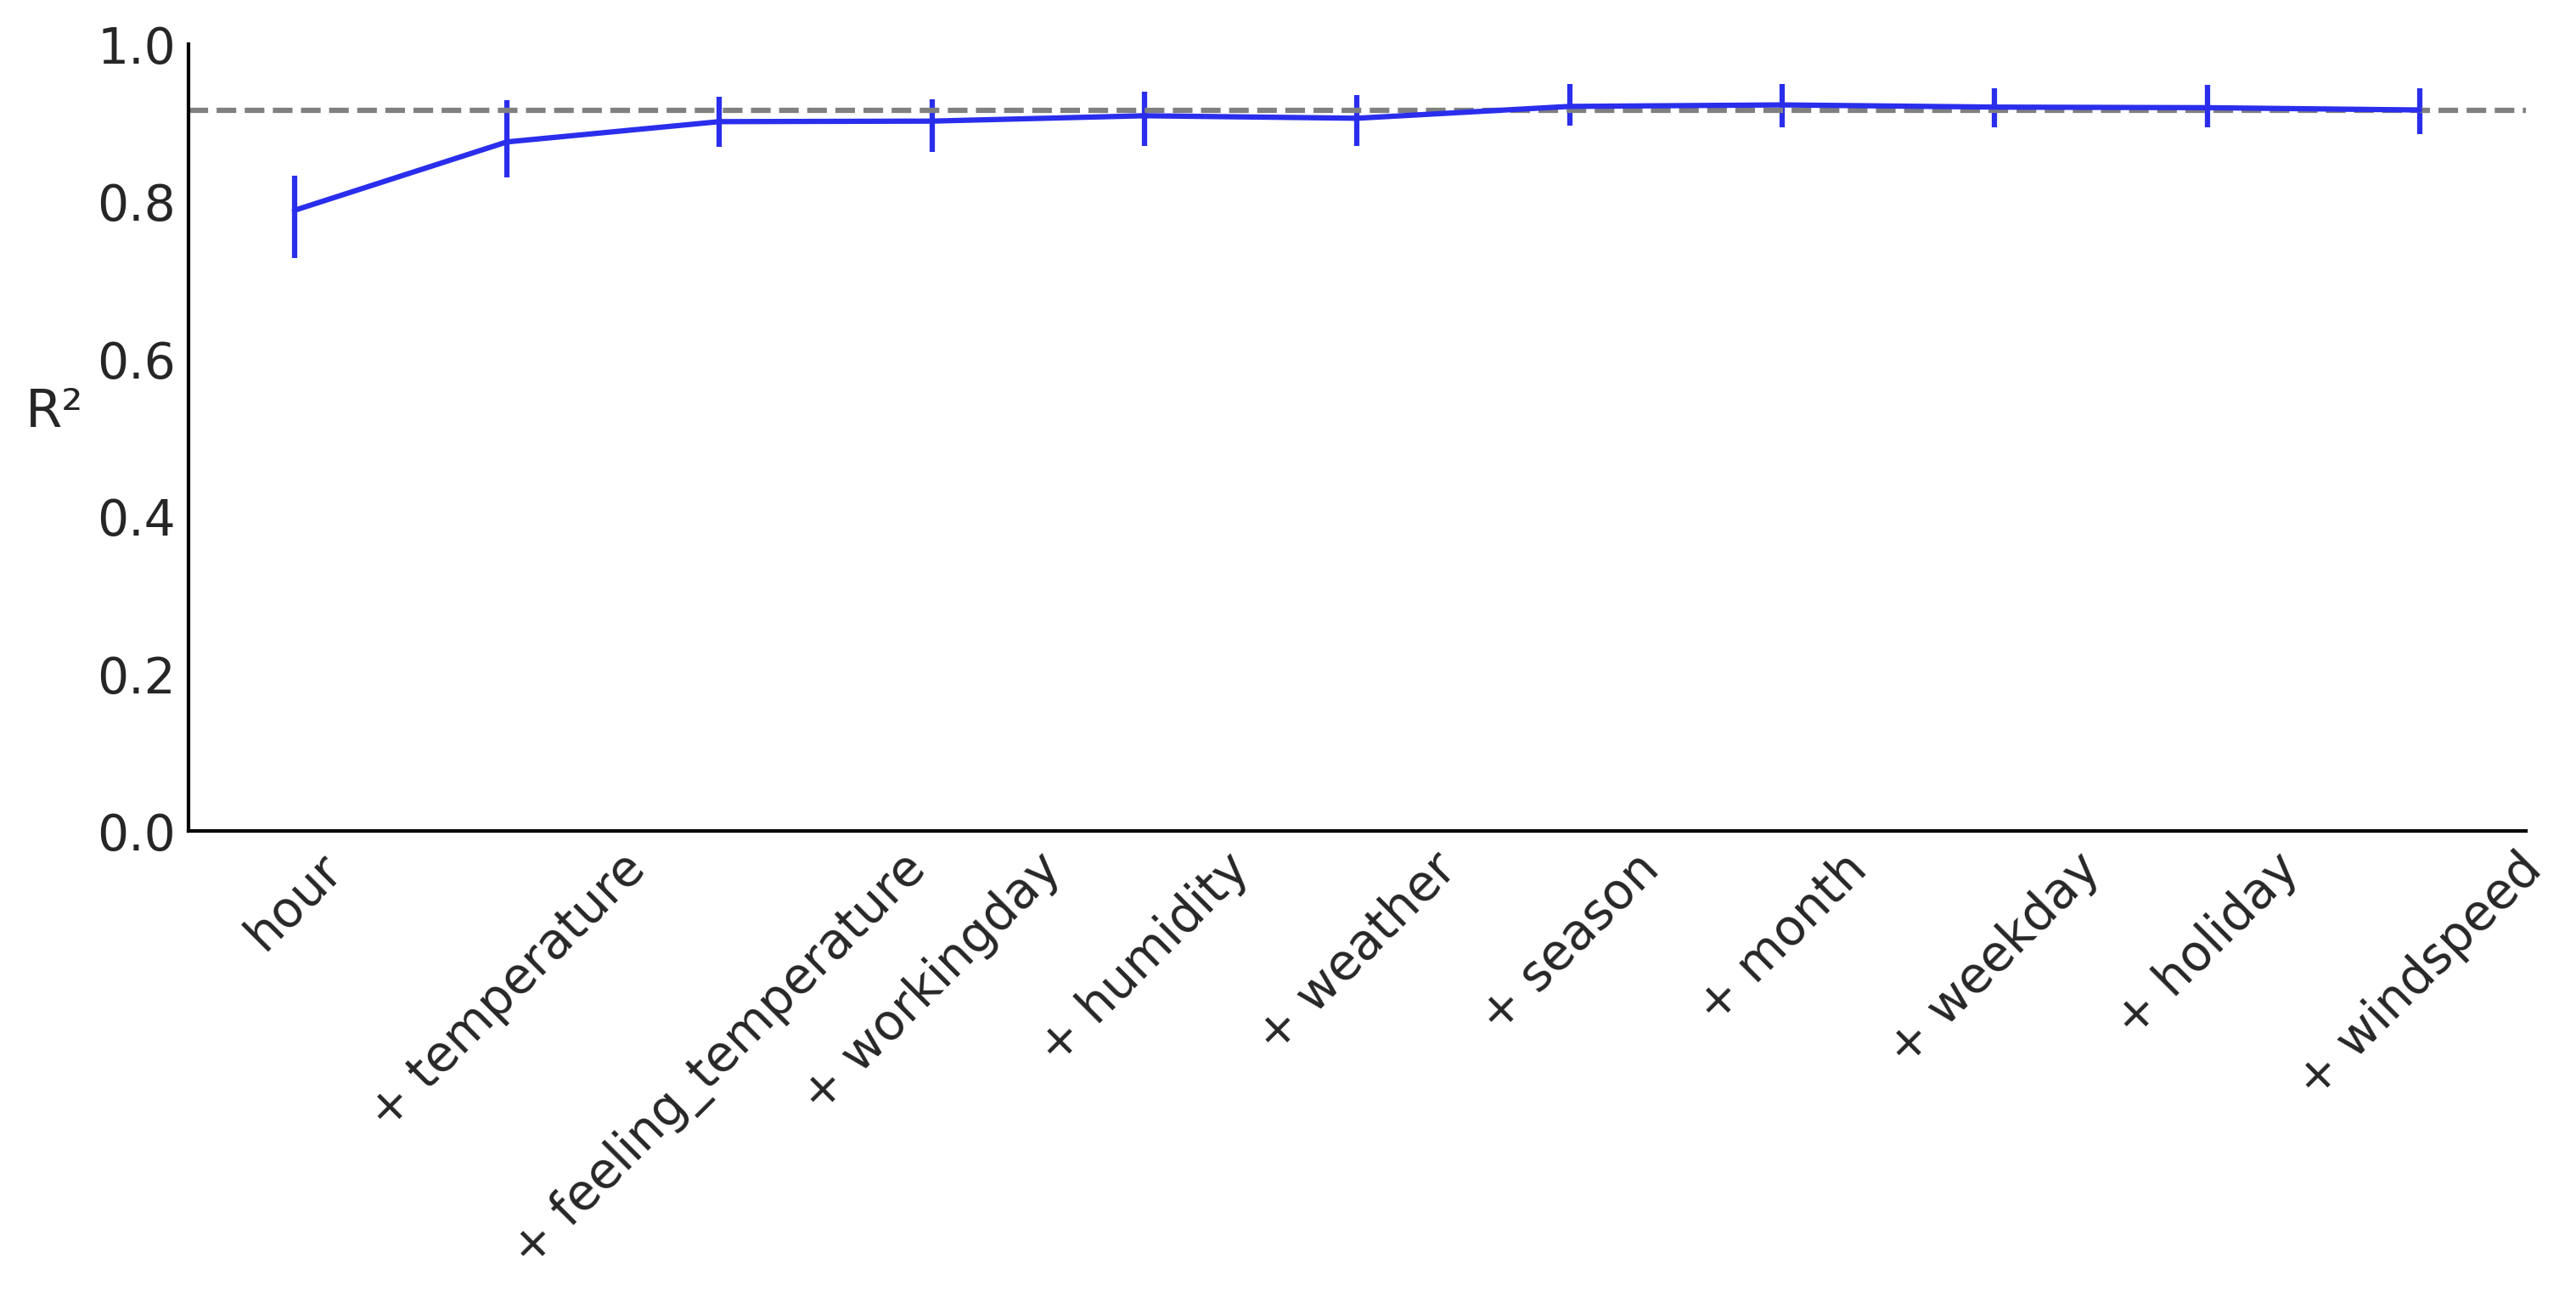

In [13]:
indices_vi_m200, _ = pmb.utils.plot_variable_importance(
    idata, μ_, X, method="VI", xlabel_angle=45, figsize=(10, 5), random_seed=RANDOM_SEED
)

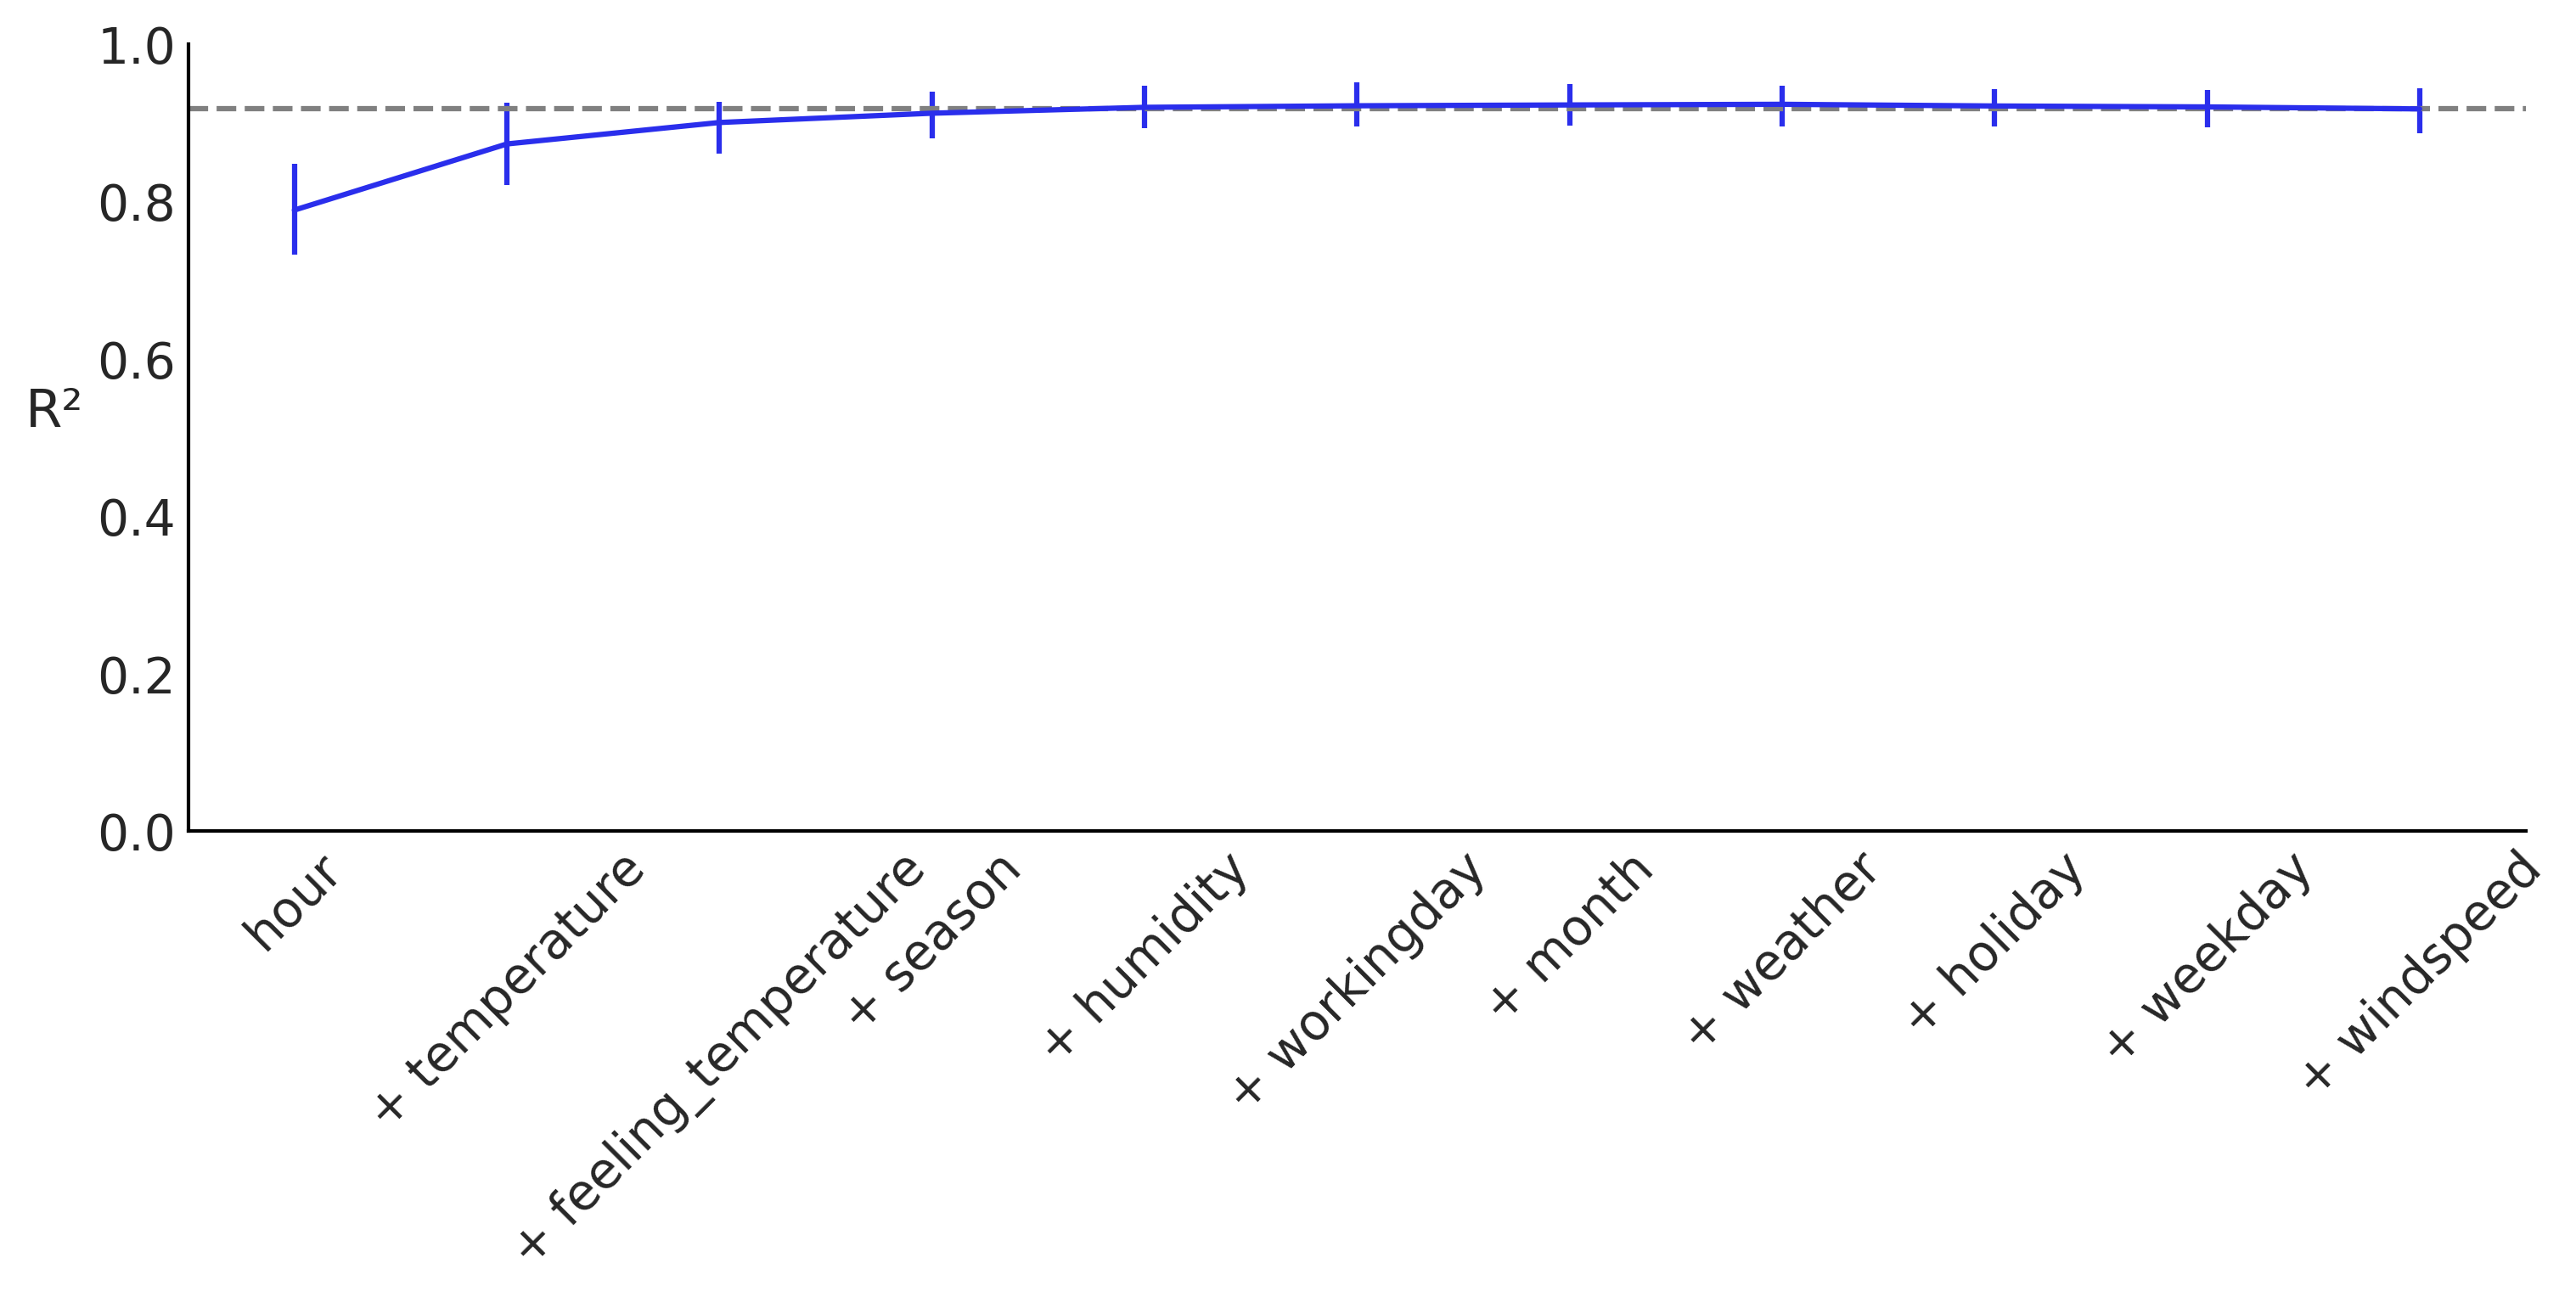

In [14]:
indices_bw_m200, _ = pmb.utils.plot_variable_importance(
    idata,
    μ_,
    X,
    method="backward",
    xlabel_angle=45,
    figsize=(10, 5),
    random_seed=RANDOM_SEED,
)

In [15]:
idatas = []
bart_rvs = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X.iloc[:, indices_vi_m200[: idx + 1]], np.log(Y), m=200)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(
            chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False
        )
        idatas.append(idata)
        bart_rvs.append(μ_)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 371 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 366 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 371 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 369 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 364 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 363 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 355 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 356 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 355 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 350 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 350 seconds.


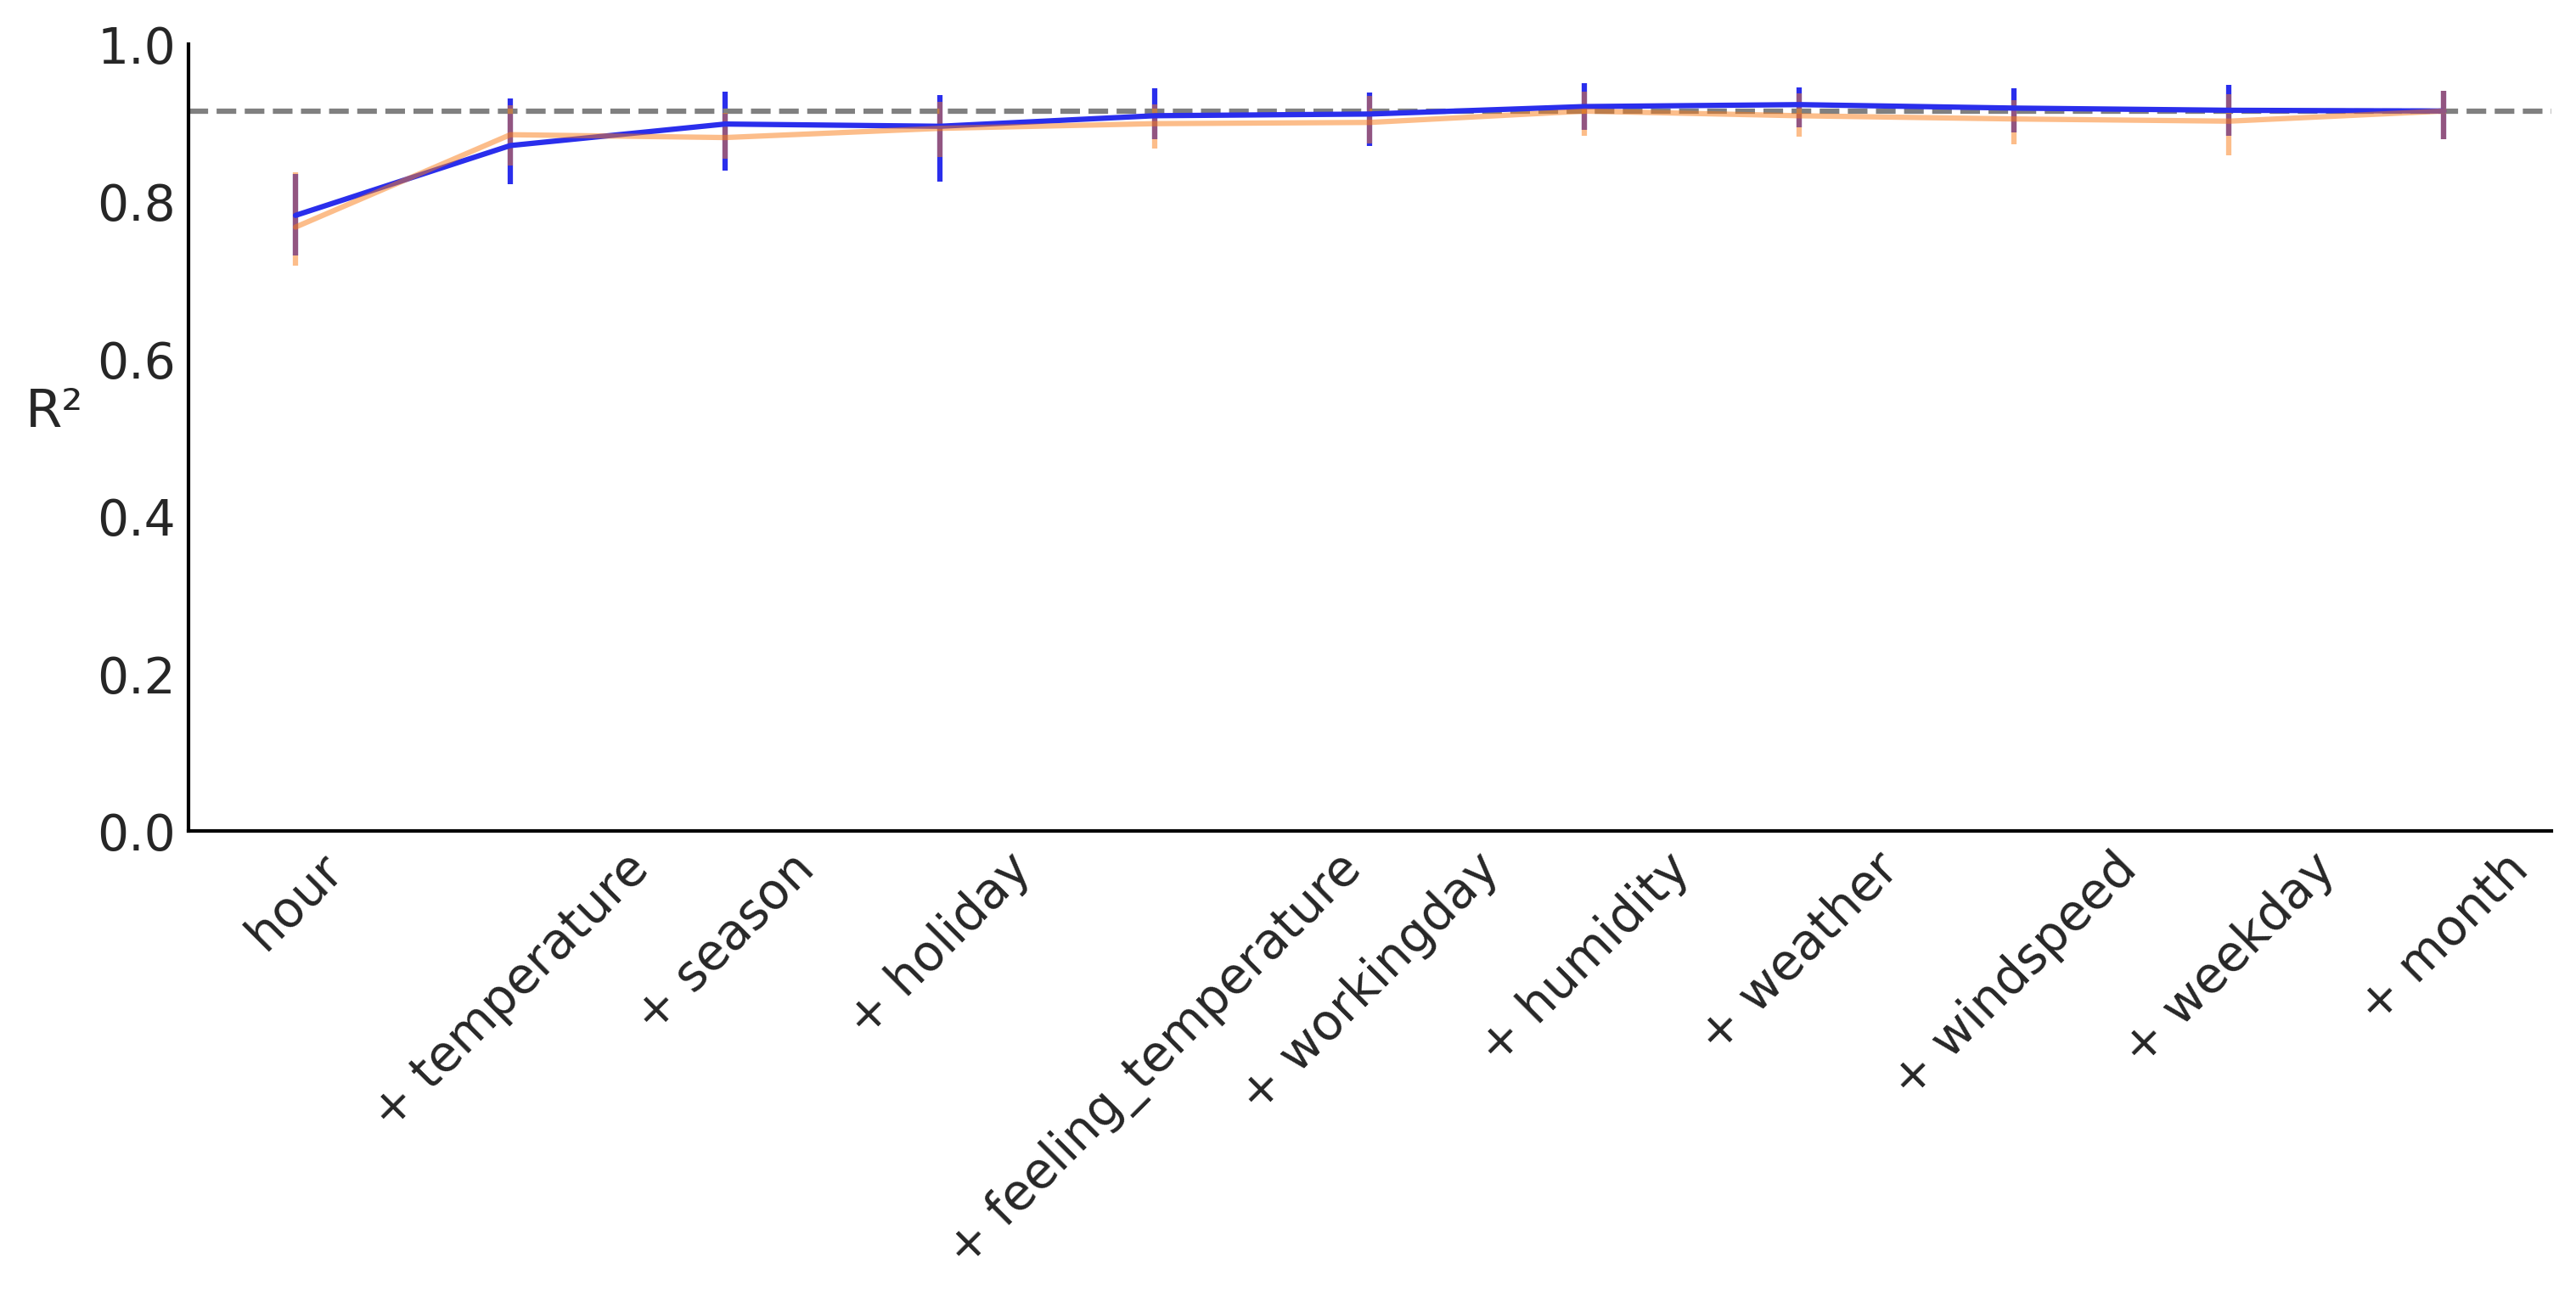

In [16]:
vi_evi(bart_rvs, idatas, X, indices_vi_m200, "VI", 100, RANDOM_SEED, figsize=(10, 5))
plt.savefig("bikes_m200_vi.png")

## Explicit computation of R² following method="backward" order, with m=200

In [17]:
idatas = []
bart_rvs = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X.iloc[:, indices_bw_m200[: idx + 1]], np.log(Y), m=200)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(
            chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False
        )
        idatas.append(idata)
        bart_rvs.append(μ_)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 355 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 350 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 351 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 349 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 349 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 352 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 350 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 352 seconds.


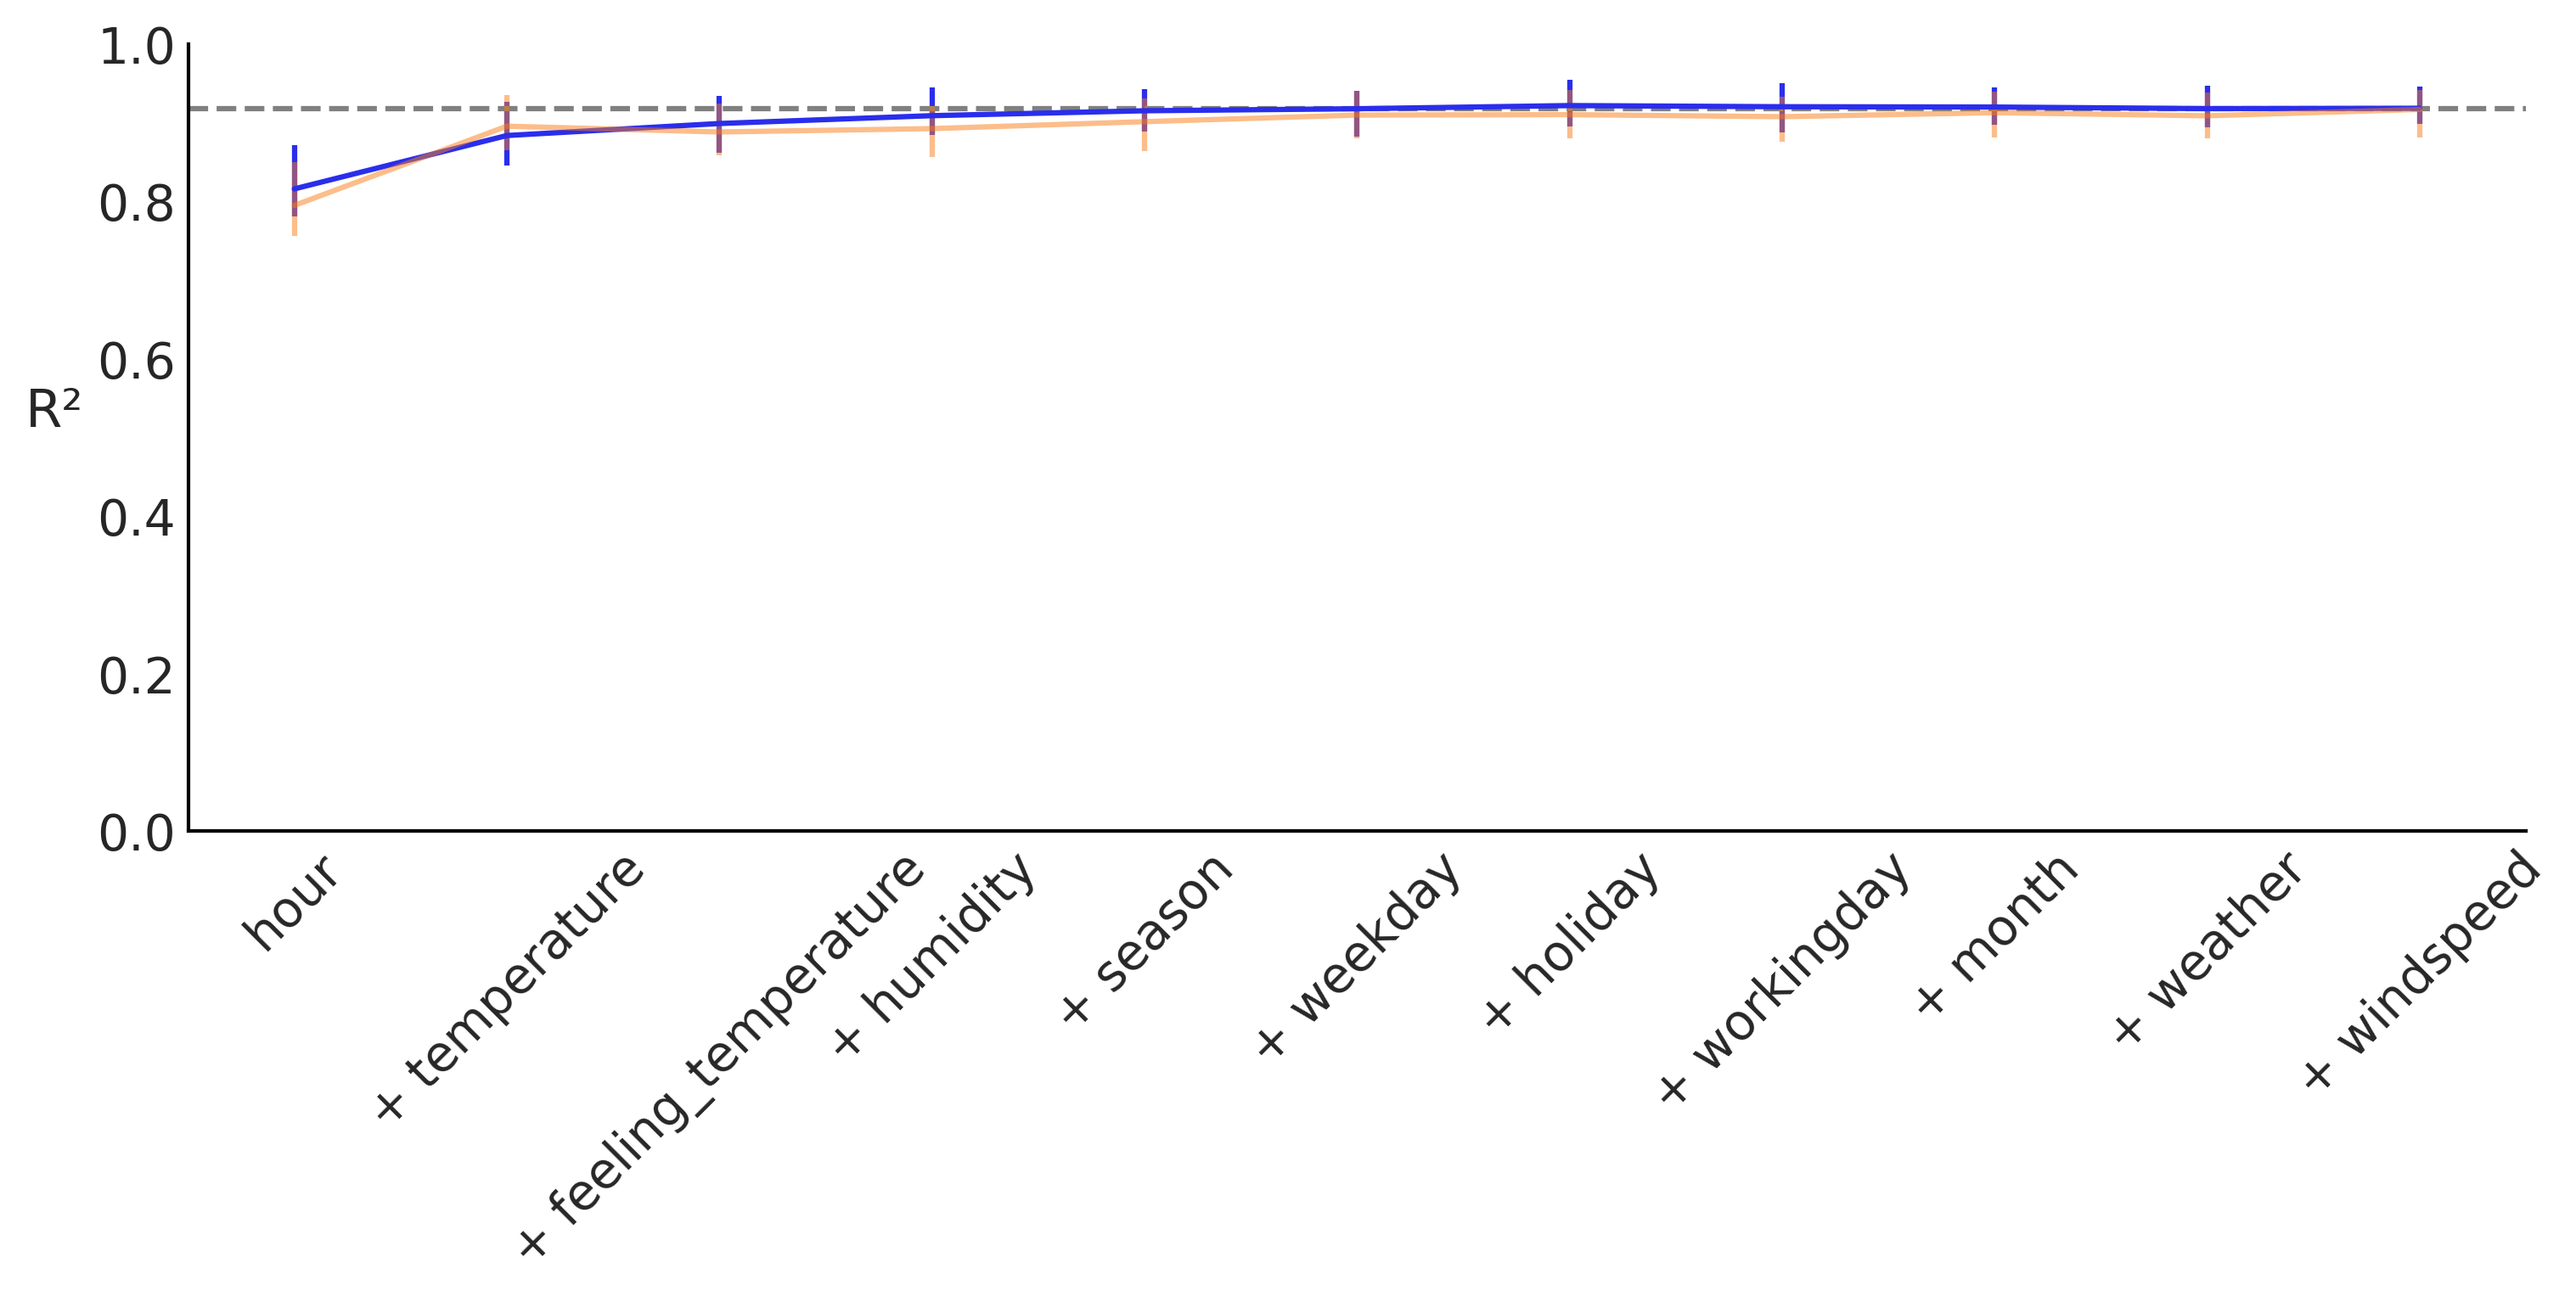

In [18]:
vi_evi(
    bart_rvs, idatas, X, indices_bw_m200, "backward", 100, RANDOM_SEED, figsize=(10, 5)
)
plt.savefig("bikes_m200_bw.png")